# Sub-section 1

In [67]:
import json
import pandas as pd
import numpy as np
import seaborn as sns

#opens json file
with open('ultimate_data_challenge.json') as f:
    json_file = json.load(f)

#turns json file to DataFrame
df = pd.DataFrame(json_file)

After looking at the last_trip_date column, it should be safe to assume that this data was pulled on 7/1/2014, and users will be considered retained if they were active on or after 6/1/2014

In [92]:
#Convert Dtype of columns to be prep'd for machine learning
df['city'] = df.city.astype('category')
df['trips_in_first_30_days'] = df.trips_in_first_30_days.astype(np.float64)
df['phone'] = df.phone.astype('category')
df['signup_date'] = pd.to_datetime(df.signup_date)
df['last_trip_date'] = pd.to_datetime(df.last_trip_date)
df['ultimate_black_user'] = df.ultimate_black_user.astype(np.float64)

#Change signup_date to only include the day, since the month and year are the same for all of them
df['signup_date'] = df.signup_date.dt.day.astype(np.float64)

#Creates Target Col for retension, as defined by the question
df['retained'] = (df.last_trip_date >= pd.Timestamp(2014,6,1)).astype(np.float64)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
city                      50000 non-null category
trips_in_first_30_days    50000 non-null float64
signup_date               50000 non-null float64
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
last_trip_date            50000 non-null datetime64[ns]
phone                     50000 non-null category
surge_pct                 50000 non-null float64
ultimate_black_user       50000 non-null float64
weekday_pct               50000 non-null float64
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
retained                  50000 non-null float64
dtypes: category(2), datetime64[ns](1), float64(10)
memory usage: 4.3 MB


Looking at the cell above, the dtype for many columns was transfromed to be prepared for machine learning.
There are three columns that have some missing values. Since 'phone' is a categorical with only 2 categoies, it seems reasonable to created a new 'Unknown' category. As for the numberic columns, a quick histogram will decide how to impute values.

In [69]:
df.phone.cat.add_categories(new_categories = 'Unknown', inplace=True)
df.phone.fillna('Unknown', inplace=True)
df.phone.value_counts()

iPhone     34582
Android    15022
Unknown      396
Name: phone, dtype: int64

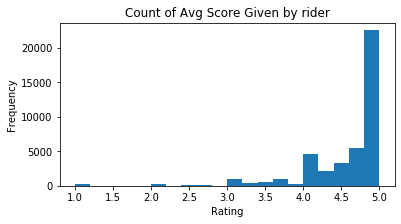

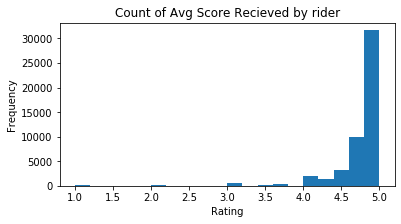

In [71]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(6,3))
plt.hist(df.avg_rating_of_driver, 20)
plt.title('Count of Avg Score Given by rider')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(6,3))
plt.hist(df.avg_rating_by_driver, 20)
plt.title('Count of Avg Score Recieved by rider')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

After plotting these historgram, it is clear that the distribution of ratings is strongly skewed left, and thus it would be better to impute the median value, rather than the mean value.

In [72]:
#Print Medians used for imputation
print('Imputed values: ')
print('avg_rating_of_driver: ', df.avg_rating_of_driver.median())
print('avg_rating_by_driver: ', df.avg_rating_by_driver.median())

#Impute values
df['avg_rating_of_driver'] = df.avg_rating_of_driver.fillna(df.avg_rating_of_driver.median())
df['avg_rating_by_driver'] = df.avg_rating_by_driver.fillna(df.avg_rating_by_driver.median())

Imputed values: 
avg_rating_of_driver:  4.9
avg_rating_by_driver:  5.0


In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
city                      50000 non-null category
trips_in_first_30_days    50000 non-null float64
signup_date               50000 non-null float64
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
last_trip_date            50000 non-null datetime64[ns]
phone                     50000 non-null category
surge_pct                 50000 non-null float64
ultimate_black_user       50000 non-null float64
weekday_pct               50000 non-null float64
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
retained                  50000 non-null float64
dtypes: category(2), datetime64[ns](1), float64(10)
memory usage: 4.3 MB


Above, it is comfirmed that Null Values have been taken care of

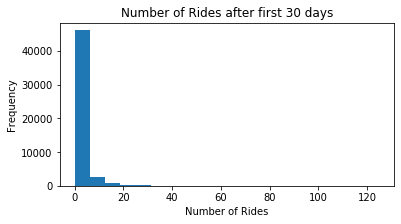

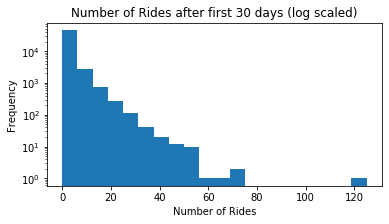

In [74]:
plt.figure(figsize=(6,3))
plt.hist(df.trips_in_first_30_days, 20)
plt.title('Number of Rides after first 30 days')
plt.xlabel('Number of Rides')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(6,3))
plt.hist(df.trips_in_first_30_days, 20, log=True)
plt.title('Number of Rides after first 30 days (log scaled)')
plt.xlabel('Number of Rides')
plt.ylabel('Frequency')
plt.show()

Looking at the distribution of Number of Rides Taken During First 30 Days, it appears that most users use it less than 20, but a decent amount will still use it between the 20 to 50 times range. Then there are a few outliers of users using it more than 50 times, including someone who rode about 120 times in one month.

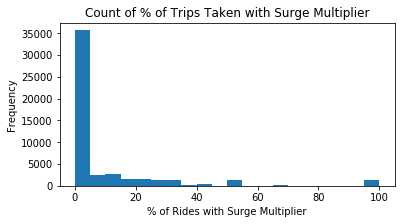

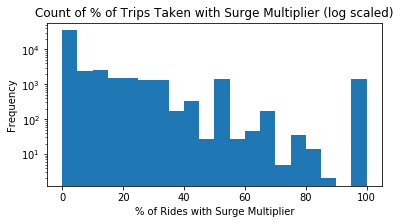

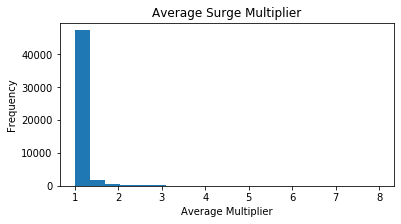

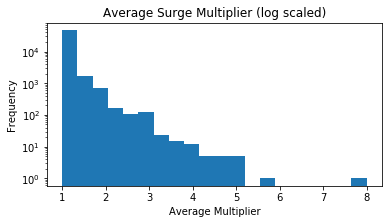

In [75]:
plt.figure(figsize=(6,3))
plt.hist(df.surge_pct, 20)
plt.title('Count of % of Trips Taken with Surge Multiplier')
plt.xlabel('% of Rides with Surge Multiplier')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(6,3))
plt.hist(df.surge_pct, 20, log=True)
plt.title('Count of % of Trips Taken with Surge Multiplier (log scaled)')
plt.xlabel('% of Rides with Surge Multiplier')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(6,3))
plt.hist(df.avg_surge, 20)
plt.title('Average Surge Multiplier')
plt.xlabel('Average Multiplier')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(6,3))
plt.hist(df.avg_surge, 20, log=True)
plt.title('Average Surge Multiplier (log scaled)')
plt.xlabel('Average Multiplier')
plt.ylabel('Frequency')
plt.show()

Analyzing percent of rides taken with surge multiplier, it appears most users don't ever (or at least rarely) have to take a ride during a surge. However, looking at the log scaled graph shows that there is still thousands of people who who have to use surge a decent amount, and even sum that exclusively have to use during high volume times. This could affect their retention rate.

The average surge multiplier has a somewhat similar pattern; most users have a multiplier of 1, but for those who ofter get charged during surge times recieve anywhere between 1.1x to 5x.

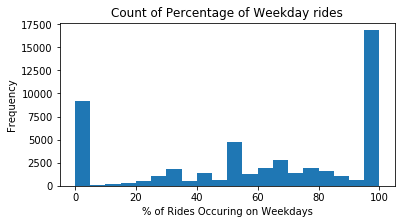

In [76]:
plt.figure(figsize=(6,3))
plt.hist(df.weekday_pct, 20)
plt.title('Count of Percentage of Weekday rides')
plt.xlabel('% of Rides Occuring on Weekdays')
plt.ylabel('Frequency')
plt.show()

Looking at the distribution of weekday_pct, the percent of uer's trips occuring during a weekday, it seems the largest group is people exclusively using the service on the weekday, the second largest group are those who exclusively use it on the weekend. However, there is still a fair amount of users that use it during both, still trending towards using it mostly on weekdays.

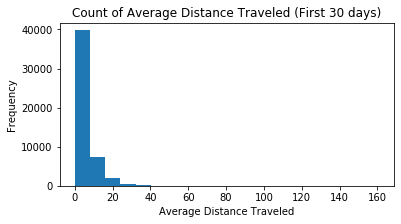

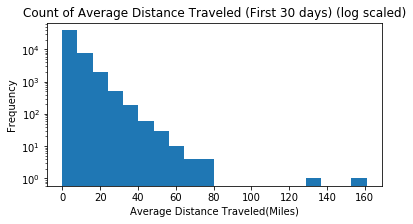

In [90]:
plt.figure(figsize=(6,3))
plt.hist(df.avg_dist, 20)
plt.title('Count of Average Distance Traveled (First 30 days)')
plt.xlabel('Average Distance Traveled')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(6,3))
plt.hist(df.avg_dist, 20, log=True)
plt.title('Count of Average Distance Traveled (First 30 days) (log scaled)')
plt.xlabel('Average Distance Traveled(Miles)')
plt.ylabel('Frequency')
plt.show()

The majority of users don't travel more than 10 miles per trip when they first signup, however, there is still a significant amount of users that go above near the 20 miles range. It could be the case that users with a high average don't have many trips.

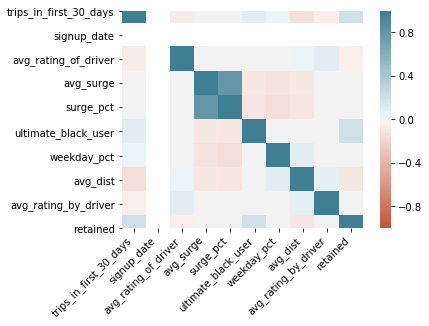

In [117]:
#This code creates correlation grid for features
corr = df.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

Looking at the correlation between columns, there doesn't seem to be any redundent columns aside from the surge columns. Since the avg_surge has more detail on the severity of the surges customers face, the surge_pct will be dropped. Note that the reason we don't want redundent features is because some algorithms, such as the logistic regression, make the assumption that the data is linearly independent.

In [77]:
percentUltimateBlackUser = len(df[df.ultimate_black_user == 1.0])/len(df) * 100
percentRetained = len(df[df.retained == 1.0])/len(df) * 100

print("Percent of Ultimate Black Users: ", round(percentUltimateBlackUser,2), "%")
print("Percent of Retained Users: ", round(percentRetained,2), "%")

Percent of Ultimate Black Users:  37.71 %
Percent of Retained Users:  37.61 %


The fraction of observed users being retained was 37.61%

It seems like a significant amount of users are retained, so it shouldn't there shouldn't be a need to use anomaly detection to find retained users. It should be noted that the percent of Ulimate Black Users being close to Percent of Retained Users is a conincidence.

# Sub-section 2

In [119]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.compose import ColumnTransformer

#remove columns that give away answers, as well as the target, then split data in to training and testing sets
#signup
X = df.drop(['last_trip_date', 'surge_pct','retained'], axis=1)
Y = df['retained']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

#columns to be stardard scaled
numeric_features = ['trips_in_first_30_days',
                    'signup_date',
                    'avg_rating_of_driver',
                    'avg_surge',
                    'weekday_pct',
                    'avg_dist',
                    'avg_rating_by_driver']

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

#Columns to one hot encoded
categorical_features = ['city',
                        'phone']

categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

#building the column transformer with both transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

#fit the preprocessor, then transform trainging and test set, assign sparse matrix to variables
preprocessor.fit(X)
encX_train = preprocessor.transform(X_train)
encX_test = preprocessor.transform(X_test)

In the cell above, the numberical data is standard scaled, and the categorical data is turned into a one hot encoding. All this is required before pushing the number into learning algorithms.

In [ ]:
def get_column_names_from_ColumnTransformer(column_transformer):    
    col_name = []
    for transformer_in_columns in column_transformer.transformers_[:-1]:#the last transformer is ColumnTransformer's 'remainder'
        raw_col_name = transformer_in_columns[2]
        if isinstance(transformer_in_columns[1],Pipeline): 
            transformer = transformer_in_columns[1].steps[-1][1]
        else:
            transformer = transformer_in_columns[1]
        try:
            names = transformer.get_feature_names()
        except AttributeError: # if no 'get_feature_names' function, use raw column name
            names = raw_col_name
        if isinstance(names,np.ndarray): # eg.
            col_name += names.tolist()
        elif isinstance(names,list):
            col_name += names    
        elif isinstance(names,str):
            col_name.append(names)
    return col_name

processedColumns = get_column_names_from_ColumnTransformer(preprocessor)

In [150]:
def graphFeatureImportance(bestfit, processedColumns, modelName, isCoef = False):

    if isCoef:
        coef_df = pd.DataFrame([processedColumns,list(bestfit.coef_[0])]).transpose().sort_values(1, ascending=False)
    else:
        coef_df = pd.DataFrame([processedColumns,list(bestfit.feature_importances_)]).transpose().sort_values(1, ascending=False)
    
    x = coef_df[0]
    y = coef_df[1]
    
    plt.figure(figsize=(7,3))
    plt.bar(x,y)
    plt.title('Feature Importance for '+ modelName)
    plt.xticks(rotation=65)
    plt.xlabel('Features')
    if isCoef:
        plt.ylabel('Coefficient')
    else:
        plt.ylabel('"Importance"')
    plt.show()

The cell above creates a list of the new columns, since one hot encoding does create new columns

Best model was:
 LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=50,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False) 
which recieved an accuracy score of:  0.7106666666666667
              precision    recall  f1-score   support

         0.0       0.72      0.88      0.79      9366
         1.0       0.68      0.43      0.53      5634

    accuracy                           0.71     15000
   macro avg       0.70      0.65      0.66     15000
weighted avg       0.71      0.71      0.69     15000



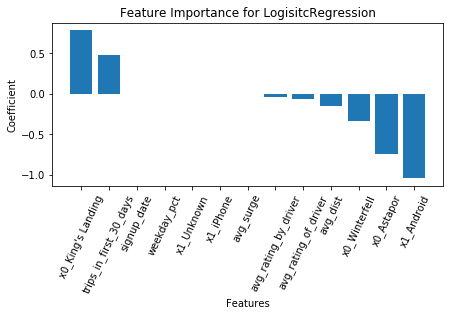

In [151]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

lr = LogisticRegression(solver= 'liblinear')
lr_para = {'C':[1.0,0.1,0.01], 
           'class_weight':[None,'balanced'],
           'max_iter':[50,100,150],
           'penalty': ['l1','l2']}

#Apply grid search with above parameters specified
fitmodel = GridSearchCV(lr, lr_para,cv=5, scoring='accuracy', n_jobs=-1)
fitmodel.fit(encX_train,y_train)

#store the best fitting LogisiticRegression(), create prediciton from X_test data
bestfitLR = fitmodel.best_estimator_

bestfitLR.fit(encX_train,y_train)
y_pred = bestfitLR.predict(encX_test)
print('Best model was:\n', bestfitLR, '\nwhich recieved an accuracy score of: ', bestfitLR.score(encX_test,y_test))

#display the result
print(classification_report(y_test, y_pred))

graphFeatureImportance(bestfitLR, processedColumns, 'LogisitcRegression', True)

Best model was:
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False) 
which recieved an accuracy score of:  0.7672
              precision    recall  f1-score   support

         0.0       0.79      0.86      0.82      9366
         1.0       0.73      0.61      0.66      5634

    accuracy                           0.77     15000
   macro avg       0.76      0.74      0.74     15000
weighted avg       0.76      0.77      0.76     15000



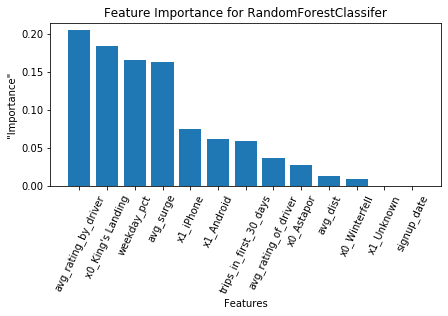

In [152]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

#define classifier and parameter grid
rf = RandomForestClassifier()
forest_para = {'criterion':['gini','entropy'],
                'min_samples_split' : range(2,6,2),
                'max_depth': range(3,7,2),
                'n_estimators':range(10,30,10)}

#Grid search to find best hyper parameters
fitmodel = GridSearchCV(rf,forest_para,cv=5, scoring='roc_auc')
fitmodel.fit(encX_train,y_train)

#store the best fitting LogisiticRegression(), create prediciton from X_test data
bestfitRF = fitmodel.best_estimator_

bestfitRF.fit(encX_train,y_train)
y_pred = bestfitRF.predict(encX_test)
print('Best model was:\n', bestfitRF, '\nwhich recieved an accuracy score of: ', bestfitRF.score(encX_test,y_test))

#display the result
print(classification_report(y_test, y_pred))

graphFeatureImportance(bestfitRF, processedColumns, 'RandomForestClassifer')

Best model was:
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=7,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False) 
which recieved an accuracy score of:  0.7848
              precision    recall  f1-score   support

         0.0       0.81      0.86      0.83      9366
         1.0       0.74      0.66      0.70      5634

    accuracy                           0.78     15000
   macro avg       0.77      0.76      0.77

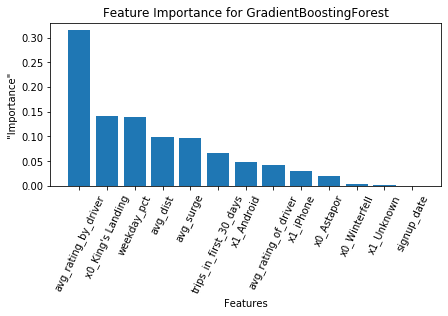

In [154]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier()
gbc_para = {'loss':['deviance', 'exponential'],
            'learning_rate': [0.1, 0.05],
            'max_depth': [3,7]}

#Apply grid search with above parameters specified
fitmodel = GridSearchCV(gbc, gbc_para,cv=5, scoring='roc_auc', n_jobs=-1)
fitmodel.fit(encX_train,y_train)

#store the best fitting GradientBoostingClassifier(), create prediciton from X_test data
bestfitGBC = fitmodel.best_estimator_

bestfitGBC.fit(encX_train,y_train)
y_pred = bestfitGBC.predict(encX_test)
print('Best model was:\n', bestfitGBC, '\nwhich recieved an accuracy score of: ', bestfitGBC.score(encX_test,y_test))

#display the result
print(classification_report(y_test, y_pred))

graphFeatureImportance(bestfitGBC, processedColumns, 'GradientBoostingForest')